TODO:
- Refine Z(t) and w(t) to match assumptions (e.g., certain hours where the parent must do chores)
- Implement different strategies (like "sleep only if baby is asleep AND we're within certain time windows" or incorporate dynamic rules) to see which yields the best cost_value
- OPTIMAL CONTROL: Update u_control to maximize cost_value (forward-backward sweep or a direct search over switching times)

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.integrate import solve_bvp

Globals and Helpers

In [27]:
# We'll store baby sleep states and parent sleep states over time (discretized).
# We'll track "epsilon" variations cumulatively

total_eps = 0.0    # For tracking baby state randomness
sleep_tracker_1 = [] # For storing parent 1's sleep/awake state at each time step
sleep_tracker_2 = [] # For storing parent 2's sleep/awake state at each time step

# constants for cost calculation
K = 1.0 # factor for the denominator
alpha = 0.5 # scales Z(t)
# delta_t = 1.0 # discrete time step (hours)

def eps_tracker(eps):
    """
    Accumulate the random perturbation (eps) to model unpredictability.
    We'll treat 'eps' as a single float, or an array chunk,
    then return the updated total.
    """
    global total_eps
    total_eps += eps
    return total_eps

def parent_sleep_tracker(val):
    """
    Append the parent's sleep/awake state for the current time step.
    """
    global sleep_tracker_1
    global sleep_tracker_2
    sleep_tracker_1.append(val[0])
    sleep_tracker_2.append(val[1])
    return sleep_tracker_1, sleep_tracker_2

Modeling Functions

In [50]:
def delta(t):
    """
    Weighted coefficient for night vs. day:
      - 0.9 if 0 < t < 8 (Night)
      - 0.1 if 8 <= t <= 24 (Day)
    """
    if 0 <= t < 8:
        return 0.9
    elif 8 <= t <= 24:
        return 0.1
    # Return something default if out of range:
    return 0.1

def B(t, eps):
    """
    Baby sleep state: 1 = baby asleep, 0 = baby awake.
    We incorporate an epsilon shift in t for unpredictability.

    we pass in a single eps or an array-based shift for discrete steps.

    We'll do a piecewise approach:
    - For 0..3 hours, baby is asleep (B=1).
    - For 3..4 hours, baby is awake (B=0).
    Then repeat every 4 hours with a shift by eps.
    """
    # Combine time with the epsilon shift:
    t_adj = t - eps  # Shift time by eps

    # Find a 4-hour block in which t_adj belongs:
    # We'll do mod 4 so it repeats:
    mod_block = t_adj % 4  # remainder in [0, 4)

    # If mod_block < 3 => baby asleep, else baby awake
    if 0 <= mod_block < 3:
        return 1
    else:
        return 0

def w(t):
    """
    Placeholder function: Work or childcare obligations at time t.
    """
    if 9 <= t < 17:
        return 1
    else:
        return 0.0

def Z(t):
    """Random baby-driven disruptions or unpredictablity (placeholder)"""
    return np.random.normal(0, 0.1)

def u_control(t, baby_state, cumulative_sleep):
    """
    The parent's control: 1 = parent chooses to sleep, 0 = parent chooses to be awake.
    This is where we can try our "optimal control" strategies or test strategies

    For now, the naive policy:
    'Parent tries to sleep if baby is asleep (B=1) and it's night.'
    """
    if w(t) ==  1 or (cumulative_sleep[0] >= 9 and cumulative_sleep[1] >=9):
      # It's 'day' and both parents have responsibilities or have already slept 10 hrs, stay up
      return [0,0]
    elif baby_state == 0:
      # baby is awake! at least one parent needs to be awake, pick the parent who's slept longer
      if cumulative_sleep[0] > cumulative_sleep[1]:
        return [0,1]
      else:
        return [1,0]
    # baby is asleep => choose whether to sleep:
    elif cumulative_sleep[0] >= 9: # Parent 1 needs no more sleep
      return [0,1]
    elif cumulative_sleep[1] >= 9: # Parent 2 needs no more sleep
      return [1,0]
    else: # Both parents need more sleep
      return [1, 1]


Derived Quantities

In [51]:
def Dp_1(time_index):
    """
    Return the parent's uninterrupted sleep duration at discrete time step 'time_index'.
    We look backward in 'sleep_tracker' until we hit an awake state (0) or start of array.
    """
    if sleep_tracker_1[time_index] == 0:
        return 0
    # Accumulate how many consecutive steps of '1' up to time_index
    dur = 0
    for i in range(time_index, -1, -1):  # walk backward
        if i == 0:
            break
        elif sleep_tracker_1[i] == 1:
            dur += 1
        else:
            break
    return dur  # in discrete steps (hours, if dt=1)

def Dp_2(time_index):
    """
    Return parent 2's uninterrupted sleep duration at discrete time step 'time_index'.
    We look backward in 'sleep_tracker' until we hit an awake state (0) or start of array.
    """
    if sleep_tracker_2[time_index] == 0:
        return 0
    # Accumulate how many consecutive steps of '1' up to time_index
    dur = 0
    for i in range(time_index, -1, -1):  # walk backward
        if i == 0:
            break
        elif sleep_tracker_2[i] == 1:
            dur += 1
        else:
            break
    return dur  # in discrete steps (hours, if dt=1)

def Np_1(time_index):
    """
    Return the number of distinct 'sleep intervals' from t0 up to time_index.
    We'll increment count each time we see a 0->1 transition in sleep_tracker.
    """
    if time_index <= 0:
        return 0
    num_naps = 0
    for i in range(1, time_index+1):
        if sleep_tracker_1[i] == 1 and sleep_tracker_1[i-1] == 0:
            num_naps += 1
    return num_naps

def Np_2(time_index):
    """
    Return the number of distinct 'sleep intervals' from t0 up to time_index.
    We'll increment count each time we see a 0->1 transition in sleep_tracker.
    """
    if time_index <= 0:
        return 0
    num_naps = 0
    for i in range(1, time_index+1):
        if sleep_tracker_2[i] == 1 and sleep_tracker_2[i-1] == 0:
            num_naps += 1
    return num_naps

Discrete Simulation

In [52]:
def simulate_day(dt=1, T=24):
    """
    Discrete simulation from t=0..T with step dt.
    We'll incorporate random eps for each step to shift baby's sleep block slightly.
    """
    global sleep_tracker_1, sleep_tracker_2, total_eps
    sleep_tracker_1 = []
    sleep_tracker_2 = []
    total_eps = 0.0

    # Create a time array from 0..T in increments dt
    t_vals = np.arange(0, T+1e-9, dt)
    # For each step, draw a random shift in epsilon:
    eps_shifts = np.random.uniform(-0.5, 0.5, size=len(t_vals))

    baby_states = []  # For storing baby state
    parent_1_states = [] # For storing parent 1's chosen control
    parent_2_states = [] # For storing parent 2's chosen control
    dp_vals = []
    np_vals = []

    # We'll accumulate the discrete cost here
    cost_value = 0.0

    for i, t in enumerate(t_vals):
        # Accumulate epsilon:
        e = eps_tracker(eps_shifts[i])
        # baby state:
        b_state = B(t, e)
        baby_states.append(b_state)

        # parent's control
        u_val = u_control(t, b_state, [sum(parent_1_states), sum(parent_2_states)])
        parent_sleep_tracker(u_val)
        parent_1_states.append(u_val[0])
        parent_2_states.append(u_val[1])

        # now that we have updated sleep_tracker, we can compute Dp, Np:
        cur_dp = [Dp_1(i), Dp_2(i)]
        cur_np = [Np_1(i), Np_2(i)]
        dp_vals.append(cur_dp)
        np_vals.append(cur_np)

        # Evaluate the integrand for the cost at this discrete step
        denom_1 = K*(cur_np[0] if cur_np[0]>0 else 1)
        denom_2 = K*(cur_np[1] if cur_np[1]>0 else 1)
        integrand = b_state * ((cur_dp[0]**2 / denom_1) + (cur_dp[1]**2 / denom_2)) - w(t) + alpha*Z(t)
        cost_value += integrand * dt

    parent_states = [parent_1_states, parent_2_states]
    return t_vals, baby_states, parent_states, dp_vals, np_vals, cost_value

Approximate cost J over 24h: 159.63918826319195


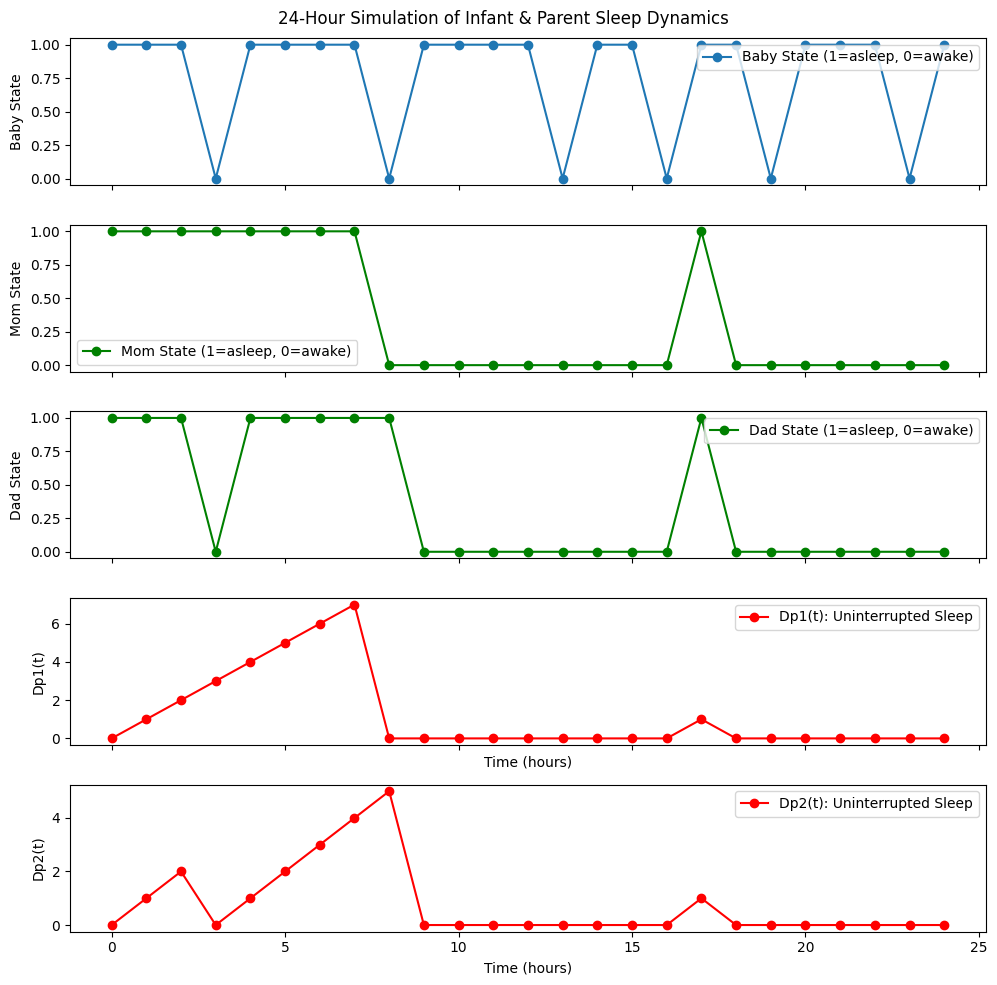

In [57]:
t_vals, baby, parent, dp_vals, np_vals, cost_est = simulate_day(dt=1, T=24)

print(f"Approximate cost J over 24h: {cost_est}")

# Plot results
fig, ax = plt.subplots(5, 1, figsize=(10, 10), sharex=True)
fig.suptitle("24-Hour Simulation of Infant & Parent Sleep Dynamics")

ax[0].plot(t_vals, baby, marker='o', label='Baby State (1=asleep, 0=awake)')
ax[0].set_ylabel('Baby State')
ax[0].legend()

ax[1].plot(t_vals, parent[0], marker='o', color='g', label='Mom State (1=asleep, 0=awake)')
ax[1].set_ylabel('Mom State')
ax[1].legend()

ax[2].plot(t_vals, parent[1], marker='o', color='g', label='Dad State (1=asleep, 0=awake)')
ax[2].set_ylabel('Dad State')
ax[2].legend()

dp_vals = np.array(dp_vals)

ax[3].plot(t_vals, dp_vals[:,0], marker='o', color='r', label='Dp1(t): Uninterrupted Sleep')
ax[3].set_ylabel('Dp1(t)')
ax[3].set_xlabel('Time (hours)')
ax[3].legend()

ax[4].plot(t_vals, dp_vals[:,1], marker='o', color='r', label='Dp2(t): Uninterrupted Sleep')
ax[4].set_ylabel('Dp2(t)')
ax[4].set_xlabel('Time (hours)')
ax[4].legend()

fig.savefig('2parentmethod.png')
plt.tight_layout()
plt.show()